<a href="https://colab.research.google.com/github/sujikathir/Restaurant-Recommendation/blob/main/Restaurant_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Machine Learning Project on Restaurant Recommendation System with Python



In [11]:
#Importing the necessary Python Libraries:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
#Load and read the dataset:
zomato_real=pd.read_csv("/content/drive/MyDrive/zomato.csv")
zomato_real.head() # prints the first 5 rows of the dataset

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


##Data cleaning and Feature engineering

1.   Deleting Unnecessary Columns
2.   Removing the Duplicates
3.   Remove the NaN values from the dataset
4.   Changing the column names
5.   Data Transformations
6.   Data Cleaning
7.   Adjust the column names




In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def missing_values(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize = 20, weight = 'bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh + 12.5, f'Columns with more than {thresh}% missing values', fontsize = 12, color = 'crimson',
         ha = 'left' ,va = 'top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha = 'left' ,va = 'top')
    plt.xlabel('Columns', size = 15, weight = 'bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight = 'bold')
    
    return plt.show()

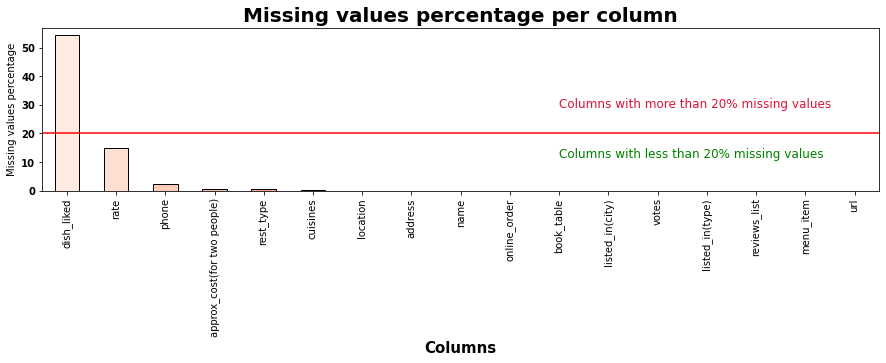

In [27]:
missing_values(zomato_real, thresh = 20, color = sns.color_palette('Reds',15))

In [3]:
#Deleting Unnnecessary Columns
zomato=zomato_real.drop(['url','dish_liked','phone'],axis=1) #Dropping the column "dish_liked", "phone", "url" and saving the new dataset as "zomato"


In [4]:
#Removing the Duplicates
zomato.duplicated().sum()
zomato.drop_duplicates(inplace=True)

In [5]:
#Remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)


In [6]:
#Changing the column names
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})

In [7]:
#Some Transformations
zomato['cost'] = zomato['cost'].astype(str) #Changing the cost to string
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.')) #Using lambda function to replace ',' from cost
zomato['cost'] = zomato['cost'].astype(float)
#Removing '/5' from Rates
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')

In [8]:
# Adjust the column names
zomato.name = zomato.name.apply(lambda x:x.title())
zomato.online_order.replace(('Yes','No'),(True, False),inplace=True)
zomato.book_table.replace(('Yes','No'),(True, False),inplace=True)

In [9]:
## Computing Mean Rating
restaurants = list(zomato['name'].unique())
zomato['Mean Rating'] = 0

for i in range(len(restaurants)):
    zomato['Mean Rating'][zomato['name'] == restaurants[i]] = zomato['rate'][zomato['name'] == restaurants[i]].mean()
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
zomato[['Mean Rating']] = scaler.fit_transform(zomato[['Mean Rating']]).round(2)

##Correlation between various factors with the rating

Plot to see which kind of restaurants can have the highest number of outlets. Most probably some coffe chain, or ice-cream chain or sweet shop or famous pizza chain like Dominos or Pizza Hut will be having the maximum number of outlets.

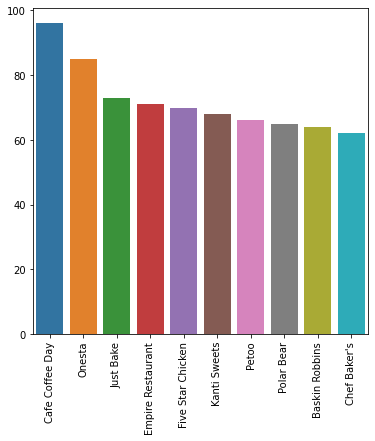

In [31]:
plt.figure(figsize = (6, 6))
zomato_real['name'].value_counts().head(10)
index = zomato_real['name'].value_counts().head(10).index
values = zomato_real['name'].value_counts().head(10).values
g = sns.barplot(x = index, y = values, data = zomato_real)
g.set_xticklabels(labels = index, rotation = 90)
g

Cafe Coffee Day(a coffee chain) had the maximum number of outlets. Sweet shops like Kanti sweet or pizza chains like Pizza Hut also have a lot of outlets across the city.

But having a large number of outlets does not gurantee a higher rating.

In [32]:
zomato_real.groupby('name')['votes', 'rate'].max().sort_values(ascending = False, by = 'votes').head(15)

,votes
name,
Byg Brewski Brewing Company,16832
Toit,14956
Truffles,14726
AB's - Absolute Barbecues,12121
The Black Pearl,10550
Big Pitcher,9300
Onesta,9085
Arbor Brewing Company,8419
Empire Restaurant,8304


Above are the 15 restaurants that have got the highest number of user votes. The ratings for these restaurants are also very high as expected. More votes most probably leads to better rating.

###Correlation between Number of cuisines with the rating

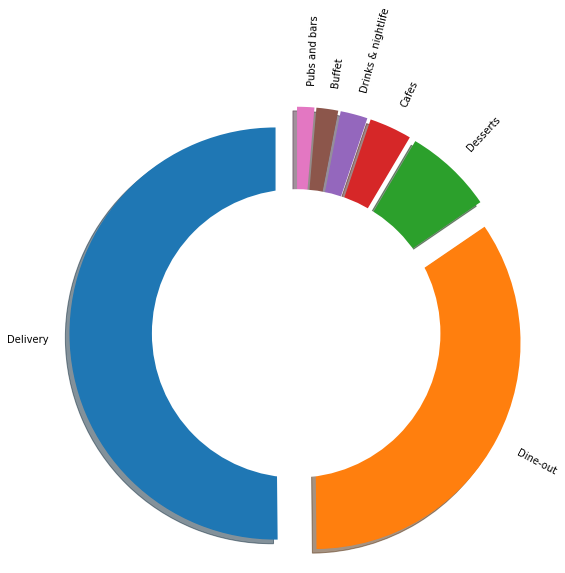

In [34]:
# Pie chart
labels = zomato_real['listed_in(type)'].value_counts().index
sizes = zomato_real['listed_in(type)'].value_counts().values
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
fig1, ax1 = plt.subplots(figsize = (8, 8))

ax1.pie(sizes, labels = labels,
        shadow = True, startangle = 90, explode = explode, rotatelabels = True)
centre_circle = plt.Circle((0, 0), 0.70,fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

###Text preprocessing

1. Lower casing
2. Removal of Punctuations
3. Removal of Stopwords
4. Removal of URLs
5. Spelling correction

In [16]:
## Lower Casing
zomato["reviews_list"] = zomato["reviews_list"].str.lower()

In [17]:
## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

zomato["reviews_list"] = zomato["reviews_list"].apply(lambda text: remove_punctuation(text))

In [20]:
## Removal of Stopwords
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

zomato["reviews_list"] = zomato["reviews_list"].apply(lambda text: remove_stopwords(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
## Removal of URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

zomato["reviews_list"] = zomato["reviews_list"].apply(lambda text: remove_urls(text))

zomato[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
2988,rated 40 ratedn havent visited place ordered f...,"Chinese, Seafood, Biryani"
3521,rated 40 ratedn love guntur nellore biryani lo...,"Andhra, Biryani, North Indian"
24872,rated 30 ratedn place good terms ambience sett...,Finger Food
9666,rated 10 ratedn bad food expected food menu wa...,"South Indian, North Indian, Chinese, Street Fo..."
10091,rated 30 ratedn cute cosy little place wooden ...,"BBQ, Continental, Burger, Wraps, Pizza, Cafe"


In [22]:
# RESTAURANT NAMES:
restaurant_names = list(zomato['name'].unique())
def get_top_words(column, top_nu_of_words, nu_of_word):
    vec = CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]
    
zomato=zomato.drop(['address','rest_type', 'type', 'menu_item', 'votes'],axis=1)
import pandas

# Randomly sample 60% of your dataframe
df_percent = zomato.sample(frac=0.5)

###TF-IDF Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) vectors for each document. This will give you a matrix where each column represents a word in the general vocabulary (all words that appear in at least one document) and each column represents a restaurant, as before.

TF-IDF is the statistical method of assessing the meaning of a word in a given document.

In [23]:
df_percent.set_index('name', inplace=True)
indices = pd.Series(df_percent.index)

# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['reviews_list'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [24]:
def recommend(name, cosine_similarities = cosine_similarities):
    
    # Create a list to put top restaurants
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'Mean Rating', 'cost'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['cuisines','Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)
    
    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))
    
    return df_new
recommend('Pai Vihar')

TOP 6 RESTAURANTS LIKE Pai Vihar WITH SIMILAR REVIEWS: 


,cuisines,Mean Rating,cost
Samosa Singh,"North Indian, Mithai",3.60,250.0
Samosa Singh,"Street Food, Fast Food, Rolls, Desserts",3.60,200.0
Juice Junction Food Court,"Beverages, Juices, Fast Food",3.50,250.0
Prasiddhi Food Corner,"Fast Food, North Indian, South Indian",3.45,200.0
Kidambi'S Kitchen,South Indian,3.17,300.0
Udupi Grand,"South Indian, North Indian, Chinese",2.91,300.0
